In [1]:
from __future__ import division
import glob
from scipy.stats import spearmanr, pearsonr, mode, linregress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches
from matplotlib import cm
import xarray as xr
mpl.style.use('ggplot')
import salem
from datetime import datetime, timedelta
import calendar
import rioxarray as rx
from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings('ignore')
import matplotlib.lines as mlines
from Shrad_modules import *
import geopandas as gpd

In [3]:
def get_annual_data(name):
    if name=='CHIRPS3.0':
        return annual_ol_chirps3, 'longitude', 'latitude'
    elif name=='CHIRP3.1':
        return annual_chirp31, 'longitude', 'latitude'
    elif name=='CHIRPS2.0':
        return annual_chirps2, 'longitude', 'latitude'
    elif name=='GPCP':
        return annual_gpcp, 'lon', 'lat'
    elif name=='GPCC':
        return annual_gpcc, 'lon', 'lat'
    
def calc_continental_mean(data, continent, lon_name, lat_name):
    for i, region in enumerate([continent]):
        shdf = continent_shp.loc[continent_shp['CONTINENT'].isin([region])]
        t2_sub = data.salem.subset(shape=shdf, margin=0)
        t2_roi = t2_sub.salem.roi(shape=shdf)
        agg_area = calc_spatial_mean(t2_roi, lon_name, lat_name)
    return agg_area

    
def calc_continental_sum(data, continent, lon_name, lat_name):
    for i, region in enumerate([continent]):
        shdf = continent_shp.loc[continent_shp['CONTINENT'].isin([region])]
        t2_sub = data.salem.subset(shape=shdf, margin=0)
        t2_roi = t2_sub.salem.roi(shape=shdf)
        agg_area = calc_spatial_integral(t2_roi, lon_name, lat_name)
    return agg_area

def read_tiff_data(file_list):
    """Read raster data from a list of file paths."""
    data = []
    for file_path in file_list:
        with rx.open_rasterio(glob.glob(file_path)[0]) as file:
            print (file_path)
            data.append(file.isel(band=0).values)
            lats, lons = file.y.values, file.x.values
    return np.stack(data), lats, lons

def plot_gridlines(ax):
    """Add gridlines to a Cartopy subplot."""
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.ylocator = mticker.FixedLocator([-90, -45, 45, 90])
    gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
    gl.xlabels_top = False
    gl.xlabels_bottom = True
    gl.ylabels_right = True
    gl.ylabels_left = False
    ax.coastlines(); ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='k'); 
    ax.add_feature(cfeature.LAND, facecolor='#AEB6BF')
    ax.add_feature(cfeature.OCEAN, facecolor=OCEAN_COLOR, zorder=100)
    return
    
def plot_colorbar(fig, cbar_axes, label, cnt_levels):
    cax = fig.add_axes(cbar_axes)
    cbar = fig.colorbar(cs, cax=cax, orientation='horizontal', ticks=cnt_levels)
    cbar.ax.tick_params(labelsize=20) 
    cbar.outline.set_edgecolor('black')
    cbar.set_label(label, fontsize=40)
    return

def calc_basin_agg(data, basin_shp, lon_name, lat_name):
    t2_sub = data.salem.subset(shape=basin_shp, margin=2)
    t2_roi = t2_sub.salem.roi(shape=basin_shp)
    agg_precip = calc_spatial_integral(t2_roi, lon_name, lat_name).resample(time='A-Sep').sum()
    return agg_precip

def cum_per_sec_to_maf(cum_per_sec):
    acre_feet_per_cum = 0.0008107132
    sec_per_year = 60 * 60 * 24 * 365.25
    maf_per_year = cum_per_sec * acre_feet_per_cum * sec_per_year / 1e6
    return maf_per_year

# Common parameters
OCEAN_COLOR = "#CCD1D1"
LAND_COLOR = '#AEB6BF'

plotdir = '/home/chc-shrad/DATA/Precipitation_Global/Plots/CHIRPS3.0_evaluation'
continent_shp = gpd.read_file('/home/chc-shrad/DATA/Polygons/Continents/Continents.shp')
continent_list = ['Africa', 'Asia', 'Australia', 'North America', 'South America', 'Europe', 'Oceania']

In [5]:
# Stack CHIRPS tiff file into CHIRPS netcdf
data, lats, lons = read_tiff_data(np.sort(glob.glob('/home/CHIRP/v3.1/annual/beta.chirp-v3.1.*')))
data_xr = xr.DataArray(data, dims=['time', 'latitude', 'longitude'], coords=[pd.date_range('1981-01-01', '2022-12-31', freq='12M'), lats, lons])
data_xr = data_xr.to_dataset(name='precip')
data_xr.to_netcdf('/home/chc-shrad/DATA/Precipitation_Global/CHIRPS/v3.0/annual/beta.chirp-v3.1.1981-2022.nc')

/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1981.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1982.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1983.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1984.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1985.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1986.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1987.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1988.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1989.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1990.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1991.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1992.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1993.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1994.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1995.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1996.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1997.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1998.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.1999.tif
/home/CHIRP/v3.1/annual/beta.chirp-v3.1.2000.tif
/home/CHIRP/v3.1/ann

In [11]:
# Import the CHIRPS-2.0 precipitation dataset and load it into the chirps2 variable.
chirps2 = xr.open_dataset('/home/chc-data-out/products/CHIRPS-2.0/global_monthly/netcdf/chirps-v2.0.monthly.nc')

# Select a specific time range from the CHIRPS-2.0 dataset using the sel() function.
chirps2 = chirps2.sel(time=slice('1981-01-01', '2022-12-31'))

# Get the latitude and longitude values from the chirps2 variable for use in cropping other precipitation datasets.
lats, lons = chirps2.coords['latitude'].values, chirps2.coords['longitude'].values

# Import the Older version of CHIRPS-3.0 precipitation dataset and crop it to match the spatial extent of chirps2 using the sel() function.
ol_chirps3 = xr.open_dataset('/home/chc-shrad/DATA/Precipitation_Global/CHIRPS/v3.0/monthly/beta.chirps-v3.0.monthly.nc')
ol_chirps3 = ol_chirps3.sel(latitude=slice(lats.max(), lats.min()), longitude=slice(lons.min(), lons.max()))

# Import the GPCC precipitation dataset and crop it to match the spatial extent of chirps2 using the sel() function.
# Adjust the longitude values to be within -180 to 180 degrees using modulo and subtraction.
gpcc = xr.open_mfdataset('/home/chc-shrad/DATA/Precipitation_Global/GPCC/full_data_monthly_v2022_*', concat_dim='time', combine='nested')
gpcc.coords['lon'] = (gpcc.coords['lon'] + 180) % 360 -180
gpcc = gpcc.sortby(gpcc.lon)
gpcc = gpcc.sel(lat=slice(lats.max(), lats.min()), lon=slice(lons.min(), lons.max()))['precip']

In [12]:
# Resample the CHIRPS-2.0 dataset to get the annual sum of precipitation using the resample() function and sum() method.
annual_chirps2 = chirps2.resample(time='A').sum(dim='time', skipna=False)

# Now writing annual chirps2 to a file to avoid future calculations
annual_chirps2.to_netcdf('/home/chc-shrad/DATA/Precipitation_Global/CHIRPS/v3.0/annual/chirps-v2.0.annual.nc')

# Resample the Old CHIRPS-3.0 dataset to get the annual sum of precipitation using the resample() function and sum() method.
annual_ol_chirps3 = ol_chirps3.resample(time='A').sum(dim='time', skipna=False)
# Now writing annual old chirpse to a file to avoid future calculations
annual_ol_chirps3.to_netcdf('/home/chc-shrad/DATA/Precipitation_Global/CHIRPS/v3.0/annual/beta.chirps-v3.0.annual.nc')

# Resample the GPCC dataset to get the annual sum of precipitation using the resample() function and sum() method.
annual_gpcc = gpcc.resample(time='A').sum(dim='time', skipna=False)
annual_gpcc = annual_gpcc.to_dataset(name='precip')
annual_gpcc.to_netcdf('/home/chc-shrad/DATA/Precipitation_Global/CHIRPS/v3.0/annual/full_data_gpcc_annual_v2022.nc')


In [22]:
annual_chirps2 = xr.open_dataset('/home/chc-shrad/DATA/Precipitation_Global/CHIRPS/v3.0/annual/chirps-v2.0.annual.nc')
lats, lons = annual_chirps2.coords['latitude'].values, annual_chirps2.coords['longitude'].values
annual_ol_chirps3 = xr.open_dataset('/home/chc-shrad/DATA/Precipitation_Global/CHIRPS/v3.0/annual/beta.chirps-v3.0.annual.nc')
annual_gpcc = xr.open_dataset('/home/chc-shrad/DATA/Precipitation_Global/CHIRPS/v3.0/annual/full_data_gpcc_annual_v2022.nc')
# reading the latest version of annual chirp (chirp3.1)
data = xr.open_dataset('/home/chc-shrad/DATA/Precipitation_Global/CHIRPS/v3.0/annual/beta.chirp-v3.1.1981-2022.nc') 
data = data.where(data['precip']>=0)
# cropping the data to match the boundary of chirps2.0 and saving the data 
annual_chirp31 = data.sel(latitude=slice(lats.max(), lats.min()), longitude=slice(lons.min(), lons.max()))
annual_chirp31.coords['time'] = annual_ol_chirps3.coords['time']
annual_chirp31 = annual_chirp31.where(annual_ol_chirps3['precip']>=0)
del data

In [13]:
data = xr.open_dataset('/home/chc-shrad/DATA/Precipitation_Global/CHIRPS/v3.0/annual/beta.chirp-v3.1.1981-2022.nc') 
data = data.where(data['precip']>=0)
# cropping the data to match the boundary of chirps2.0 and saving the data 
annual_chirp31 = data.sel(latitude=slice(lats.max(), lats.min()), longitude=slice(lons.min(), lons.max()))

/home/chc-shrad/DATA/Precipitation_Global/Plots/CHIRPS3.0_evaluation/plot_annual_mean_timeseries_global.png


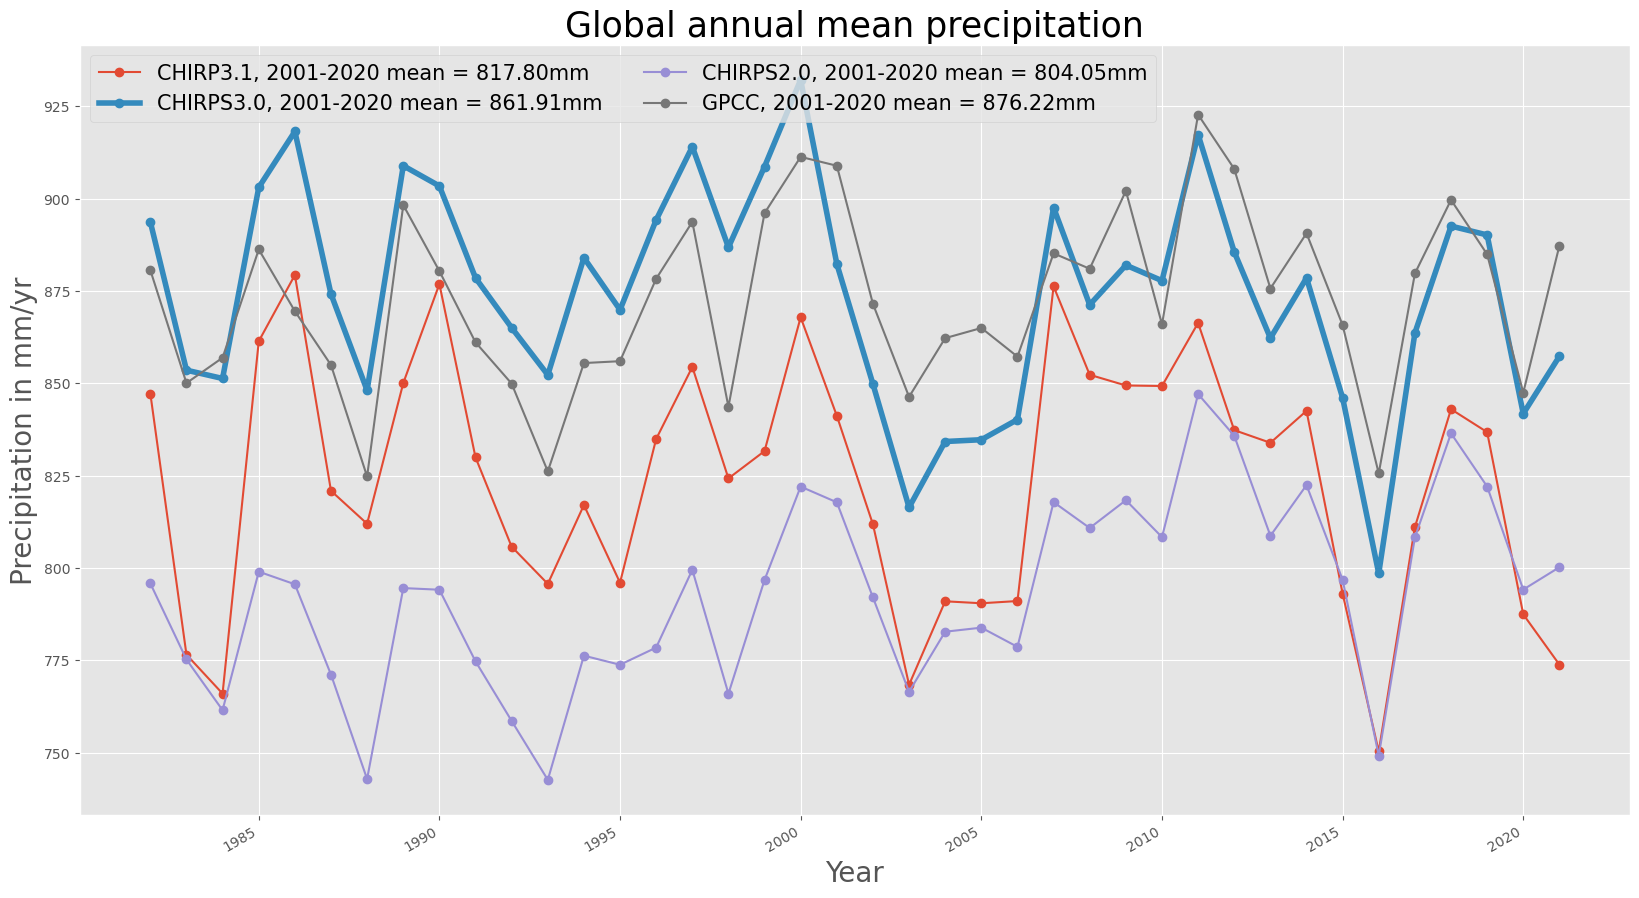

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.2)
sdate, edate = '1981-1-1', '2020-12-31'
data_list = ['CHIRP3.1', 'CHIRPS3.0', 'CHIRPS2.0', 'GPCC']
ax = axes
for data_name in data_list:
    data, lon_name, lat_name = get_annual_data(data_name) ## extracting data
    data_ts = calc_spatial_mean(data.sel(time=slice(sdate, edate)), lon_name, lat_name)
    mean = float(data_ts.sel(time=slice('2001-01-01', '2020-12-31')).mean(dim='time')['precip'].values)
    if (data_name=='CHIRPS3.0'):
        data_ts['precip'].plot(ax=ax, marker='o', lw=4, label='{}, 2001-2020 mean = {:0.2f}mm'.format(data_name, mean))
    else:
        data_ts['precip'].plot(ax=ax, marker='o', label='{}, 2001-2020 mean = {:0.2f}mm'.format(data_name, mean))

ax.legend(fontsize=15, ncol=2)
ax.set_ylabel('Precipitation in mm/yr', fontsize=20)
ax.set_title('{} annual mean precipitation'.format('Global'), fontsize=25)
ax.set_xlabel('Year', fontsize=20)
Figure = '{}/plot_annual_mean_timeseries_global.png'.format(plotdir)
print (Figure)
plt.savefig(Figure, dpi=150, format='png', bbox_inches='tight')

Africa
Asia
Australia
North America
South America
Europe
Oceania


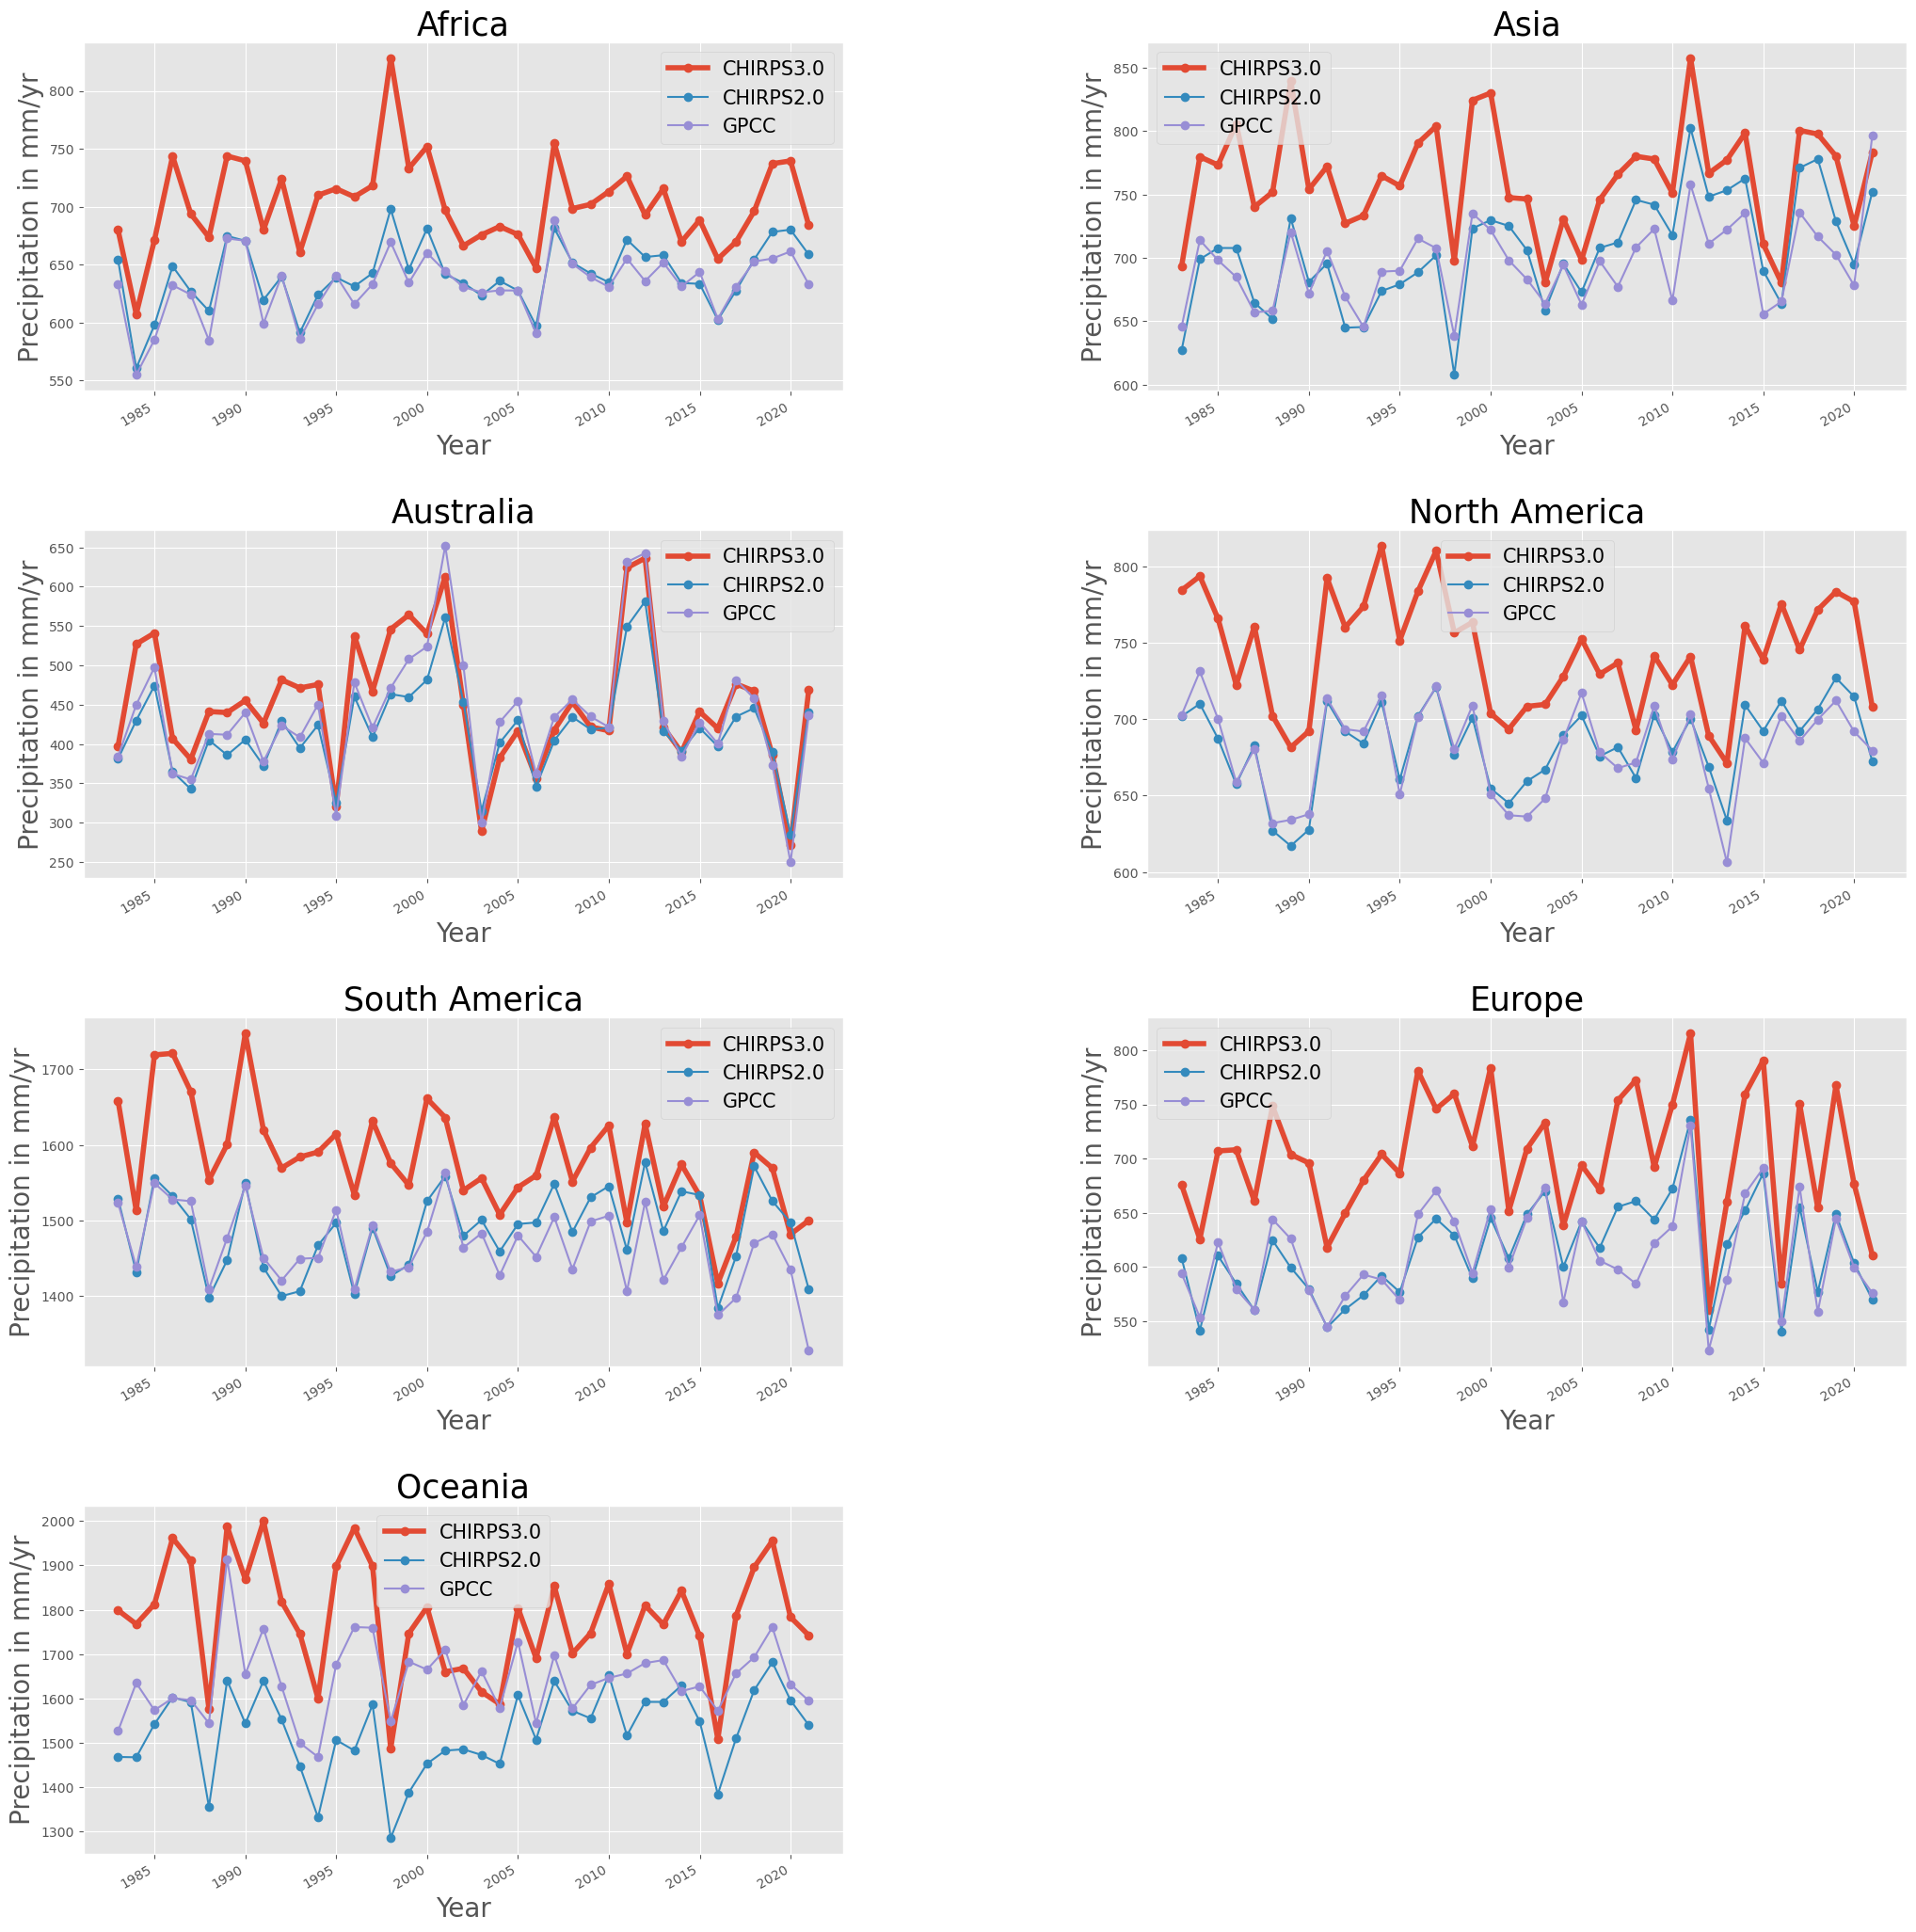

In [12]:
# Create a figure with 3 rows and 2 columns of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Adjust the spacing between subplots
fig.subplots_adjust(wspace=0.4, hspace=0.4)

# Define the start and end dates of the time series
sdate, edate = '1982-1-1', '2020-12-31'

# Define a list of data sources to plot
data_list = ['CHIRPS3.0', 'CHIRPS2.0', 'GPCC']

# Loop over each continent and plot the data sources on separate subplots
for i, region in enumerate(continent_list):
    print (region)
    ax=axes[i]
    
    # Loop over each data source and plot its time series
    for data_name in data_list:
        data, lon_name, lat_name = get_annual_data(data_name) # Extract data from file
        data_ts = calc_continental_mean(data.sel(time=slice(sdate, edate)), region, lon_name, lat_name) # Calculate spatial mean
        if (data_name=='CHIRPS3.0'):
            data_ts['precip'].plot(ax=ax, marker='o', lw=4, label=data_name) # Plot CHIRPS 3.0 with thicker line
        else:
            data_ts['precip'].plot(ax=ax, marker='o', label=data_name)
    
    # Set the legend, ylabel, title, and xlabel for each subplot
    ax.legend(fontsize=15, ncol=1)
    ax.set_ylabel('Precipitation in mm/yr', fontsize=20)
    ax.set_title('{}'.format(region), fontsize=25)
    ax.set_xlabel('Year', fontsize=20)

fig.delaxes(axes[i+1])

# Define the filename for the output figure
Figure = '{}/plot_annual_mean_timeseries_all_continents.png'.format(plotdir)

# Save the figure as a png file with dpi=150 and tight bounding box
plt.savefig(Figure, dpi=150, format='png', bbox_inches='tight')

In [87]:
annual_mean_diff = annual_chirps3.mean(dim='time')-annual_chirps2.mean(dim='time')
annual_std_diff = annual_chirps3.std(dim='time')-annual_chirps2.std(dim='time')

/home/chc-shrad/DATA/Precipitation_Global/Plots/CHIRPS3.0_evaluation/plot_annual_mean_std_diff_chirps3-chirps2.png


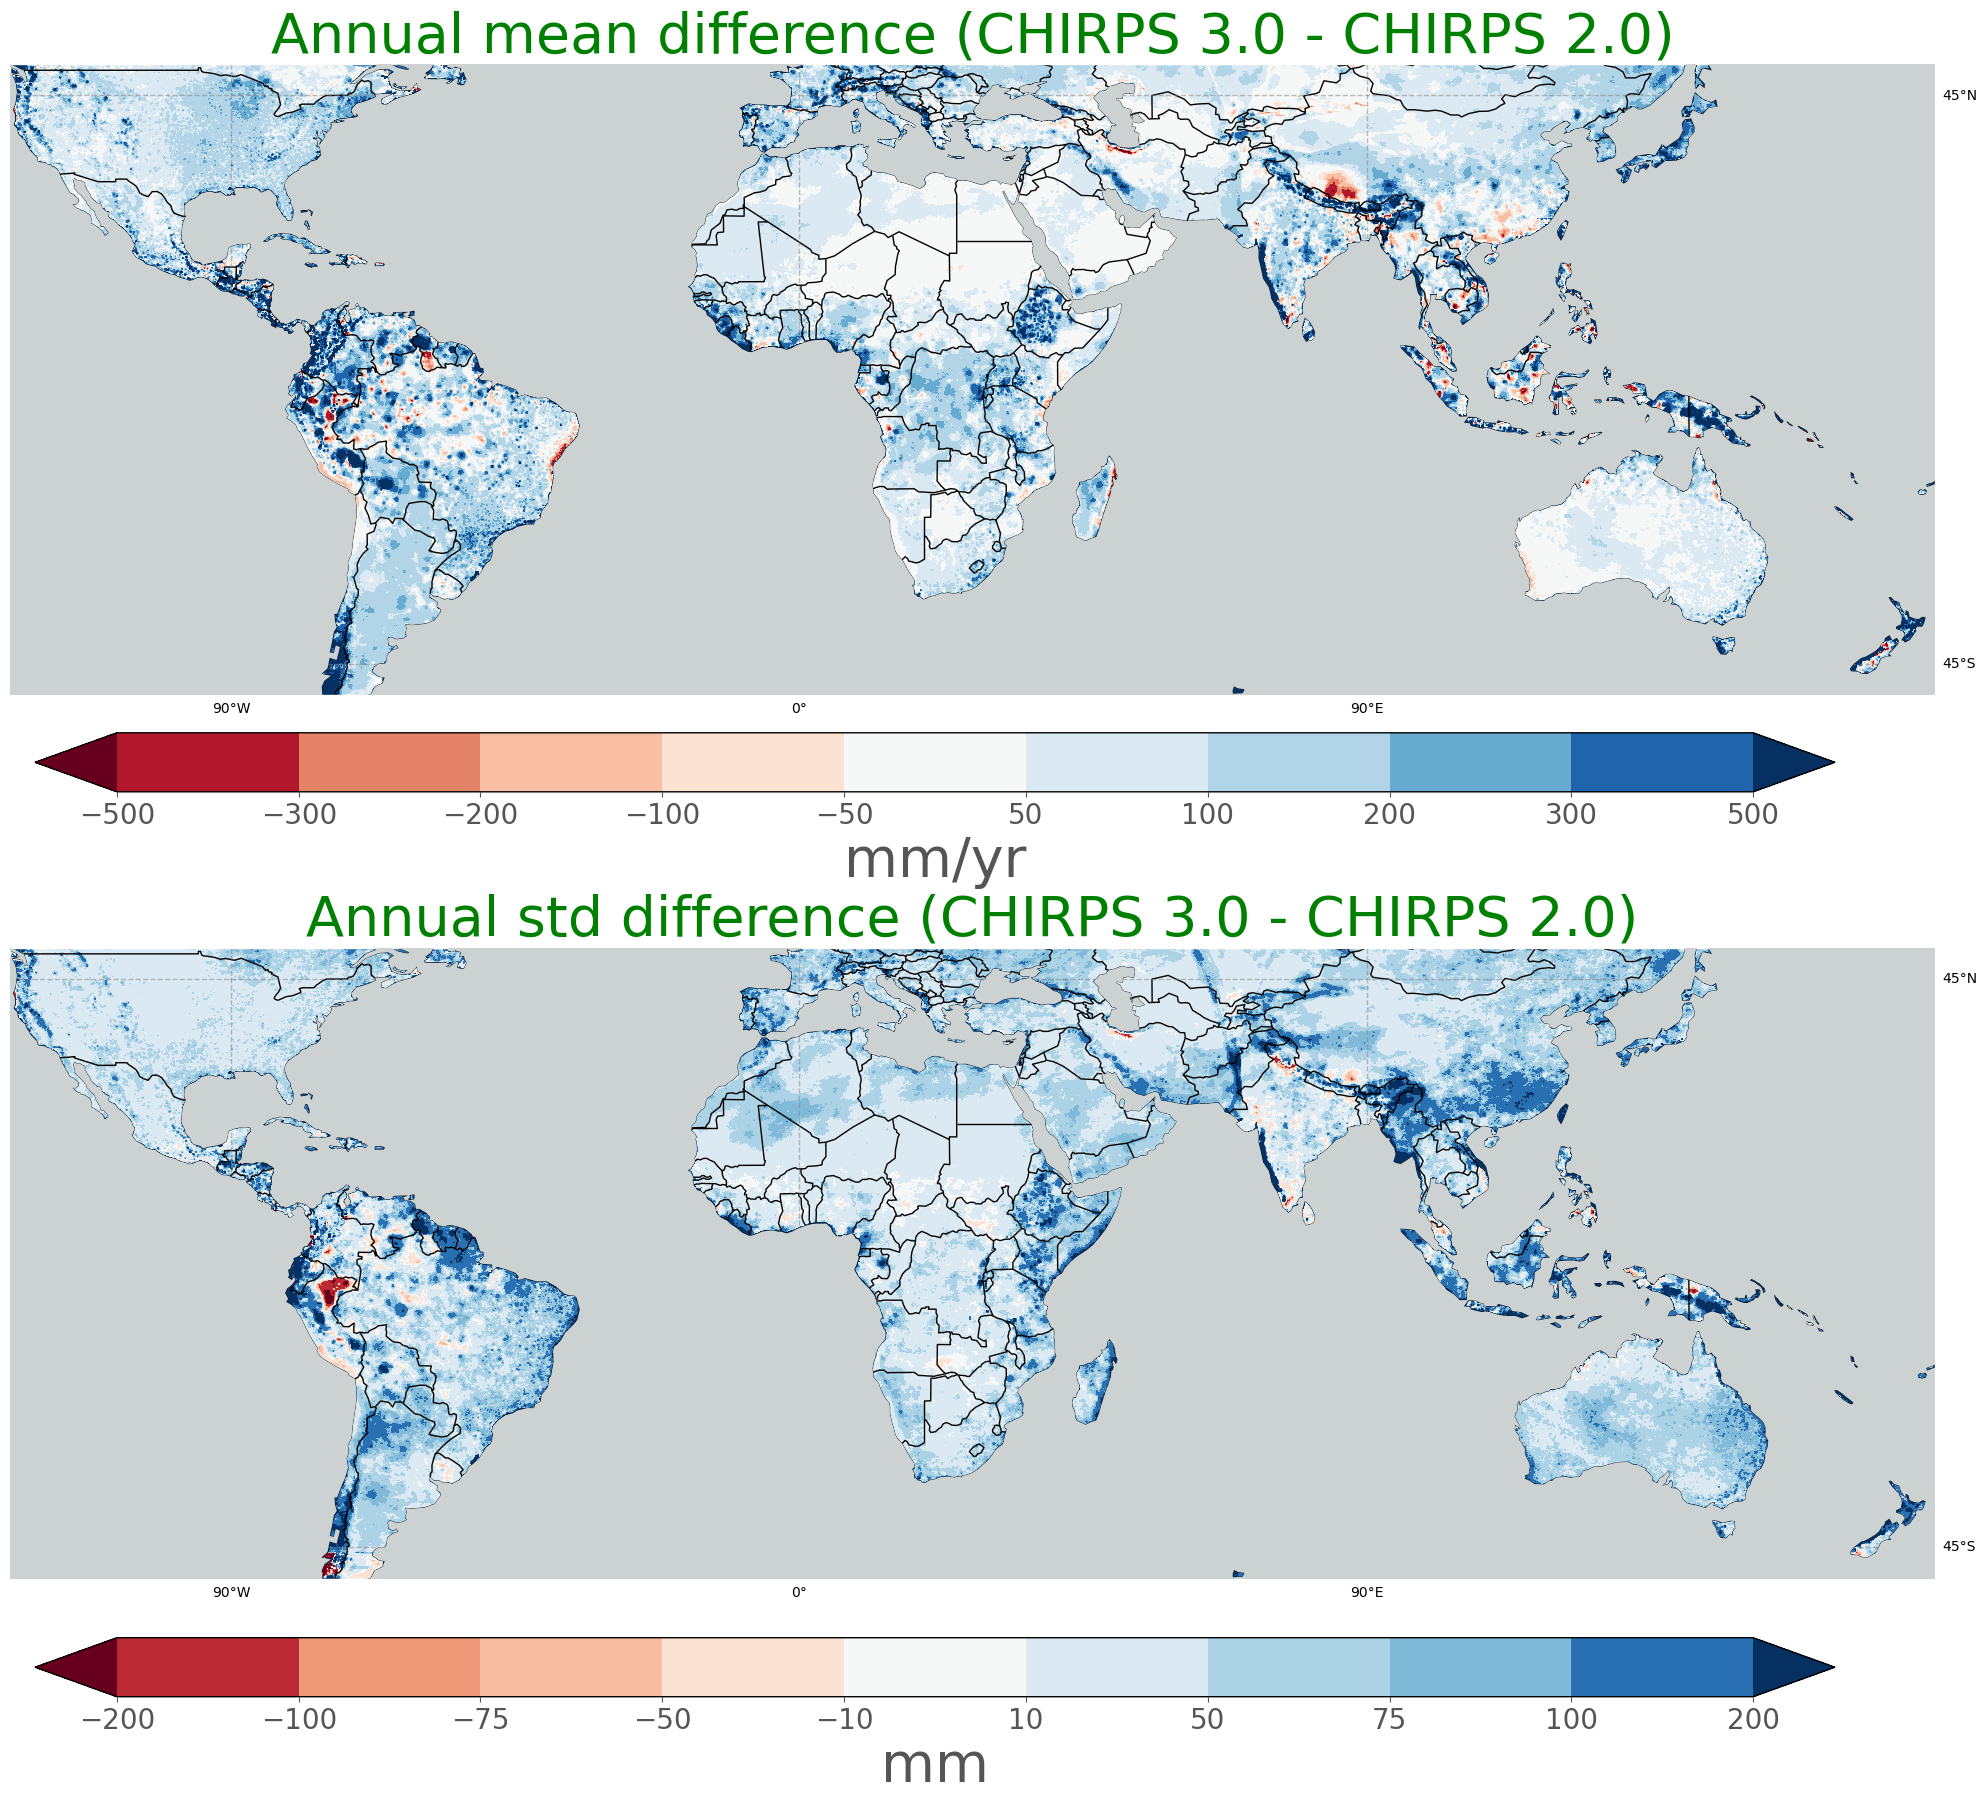

In [101]:
cmap='RdBu'
extend = 'both'

nrows, ncols = 2, 1
lat_min, lat_max, lon_min, lon_max = -50, 50, -125, 180
img_extent = (lon_max, lon_min, lat_min, lat_max)
figwidth = 30; height = nrows * (lat_max - lat_min); width = ncols * (lon_max - lon_min)
figheight = (figwidth/width)*height
# Create all subplots at once using plt.subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(figwidth, figheight))
fig.subplots_adjust(wspace=0.4, hspace=0.4)
axes = axes.flatten()

## Plotting difference in the annual mean
ax=axes[0]
cnt_levels = [-500, -300, -200, -100, -50, 50, 100, 200, 300, 500]
cbar_axes = [0.2, 0.51, 0.6, 0.03]
ax.set_extent(img_extent, ccrs.PlateCarree())
ax.set_title('Annual mean difference (CHIRPS 3.0 - CHIRPS 2.0)', fontsize=40, color='green')
# Now plot data
cs = ax.contourf(lons, lats, annual_mean_diff['precip'].values, cnt_levels, cmap=cmap, extend=extend, transform=ccrs.PlateCarree())
# Plotting grid lines 
plot_gridlines(ax)

# Plotting common colorbar
plot_colorbar(fig, cbar_axes, 'mm/yr', cnt_levels)

## Plotting difference in the annual mean
ax=axes[1]
cnt_levels = [-200, -100, -75, -50, -10, 10, 50, 75, 100, 200]
cbar_axes = [0.2, 0.05, 0.6, 0.03]
ax.set_extent(img_extent, ccrs.PlateCarree())
ax.set_title('Annual std difference (CHIRPS 3.0 - CHIRPS 2.0)', fontsize=40, color='green')
# Now plot data
cs = ax.contourf(lons, lats, annual_std_diff['precip'].values, cnt_levels, cmap=cmap, extend=extend, transform=ccrs.PlateCarree())
# Plotting grid lines 
plot_gridlines(ax)
# Plotting colorbar
plot_colorbar(fig, cbar_axes, 'mm', cnt_levels)

Figure = '{}/plot_annual_mean_std_diff_chirps3-chirps2.png'.format(plotdir)
print (Figure)
plt.savefig(Figure, dpi=150, format='png', bbox_inches='tight')

1981 2022
1981 2001
2002 2022
/home/chc-shrad/DATA/Precipitation_Global/Plots/CHIRPS3.0_evaluation/plot_annual_mean_correlation_chirps3-chirps2.png


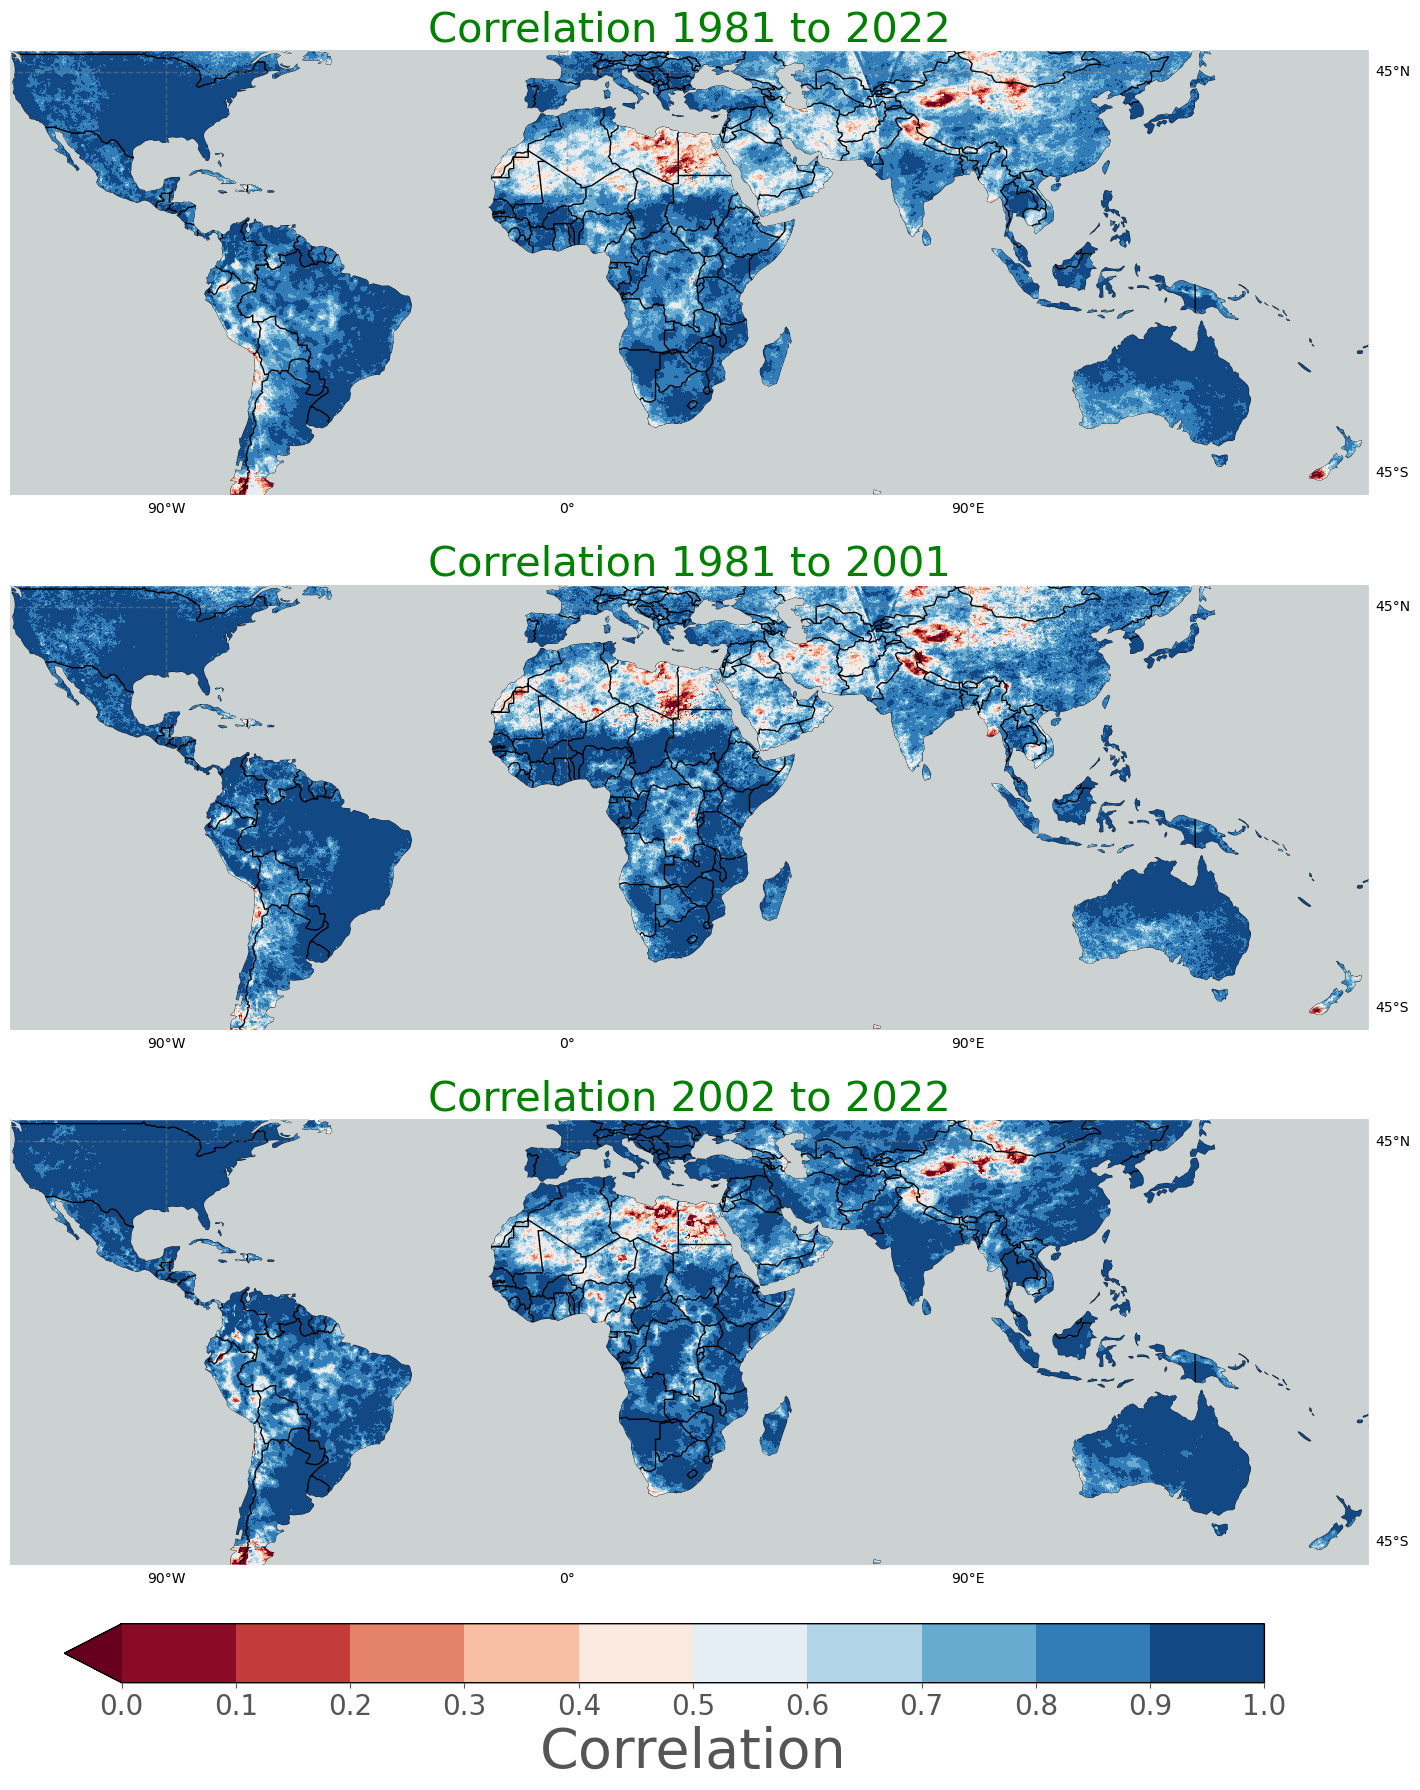

In [126]:
cmap='RdBu'
extend = 'min'
nrows, ncols = 3, 1
lat_min, lat_max, lon_min, lon_max = -50, 50, -125, 180
img_extent = (lon_max, lon_min, lat_min, lat_max)
figwidth = 20; height = nrows * (lat_max - lat_min); width = ncols * (lon_max - lon_min)
figheight = (figwidth/width)*height
# Create all subplots at once using plt.subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(figwidth, figheight))
fig.subplots_adjust(wspace=0.2, hspace=0.2)
axes = axes.flatten()

## Plotting difference in the annual mean
cnt_levels = np.arange(0, 1.1, 0.1)
cbar_axes = [0.2, 0.05, 0.6, 0.03]
cnt_ax = 0
for syr, eyr in zip([1981, 1981, 2002,], [2022, 2001, 2022]):
    print (syr, eyr)
    ax=axes[cnt_ax]; cnt_ax+=1
    
    annual_corr = xr.corr(annual_chirps3['precip'].sel(time=slice('{}-01-01'.format(syr), '{}-12-31'.format(eyr))), 
                      annual_chirps2['precip'].sel(time=slice('{}-01-01'.format(syr), '{}-12-31'.format(eyr))), dim='time')
    
    ax.set_extent(img_extent, ccrs.PlateCarree())
    ax.set_title('Correlation {} to {}'.format(syr, eyr), fontsize=30, color='green')
    # Now plot data
    cs = ax.contourf(lons, lats, annual_corr.values, cnt_levels, cmap=cmap, extend=extend, transform=ccrs.PlateCarree())
    # Plotting grid lines 
    plot_gridlines(ax)
# Plotting common colorbar
plot_colorbar(fig, cbar_axes, 'Correlation', cnt_levels)
Figure = '{}/plot_annual_mean_correlation_chirps3-chirps2.png'.format(plotdir)
print (Figure)
plt.savefig(Figure, dpi=150, format='png', bbox_inches='tight')

In [128]:
basin_shp = gpd.read_file('/home/chc-shrad/DATA/GRDC/USA/subregions.north_america.shp')
precip_df = pd.read_csv('/home/chc-shrad/DATA/Precipitation_Global/CHIRPS/v3.0/monthly/compare_conus_subregion_average_total_rainfall.csv')
merged_df = pd.merge(precip_df, basin_shp, on='FID')
merged_df['chirps3-prism'] = merged_df['chirps3'] - merged_df['prism']
merged_df['chirps2-prism'] = merged_df['chirps2'] - merged_df['prism']
merged_df['gridmet-prism'] = merged_df['gridmet'] - merged_df['prism']
merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry', crs='EPSG:4326')

/home/chc-shrad/DATA/Precipitation_Global/Plots/CHIRPS3.0_evaluation/plot_difference_basin_avg_precip_conus.png


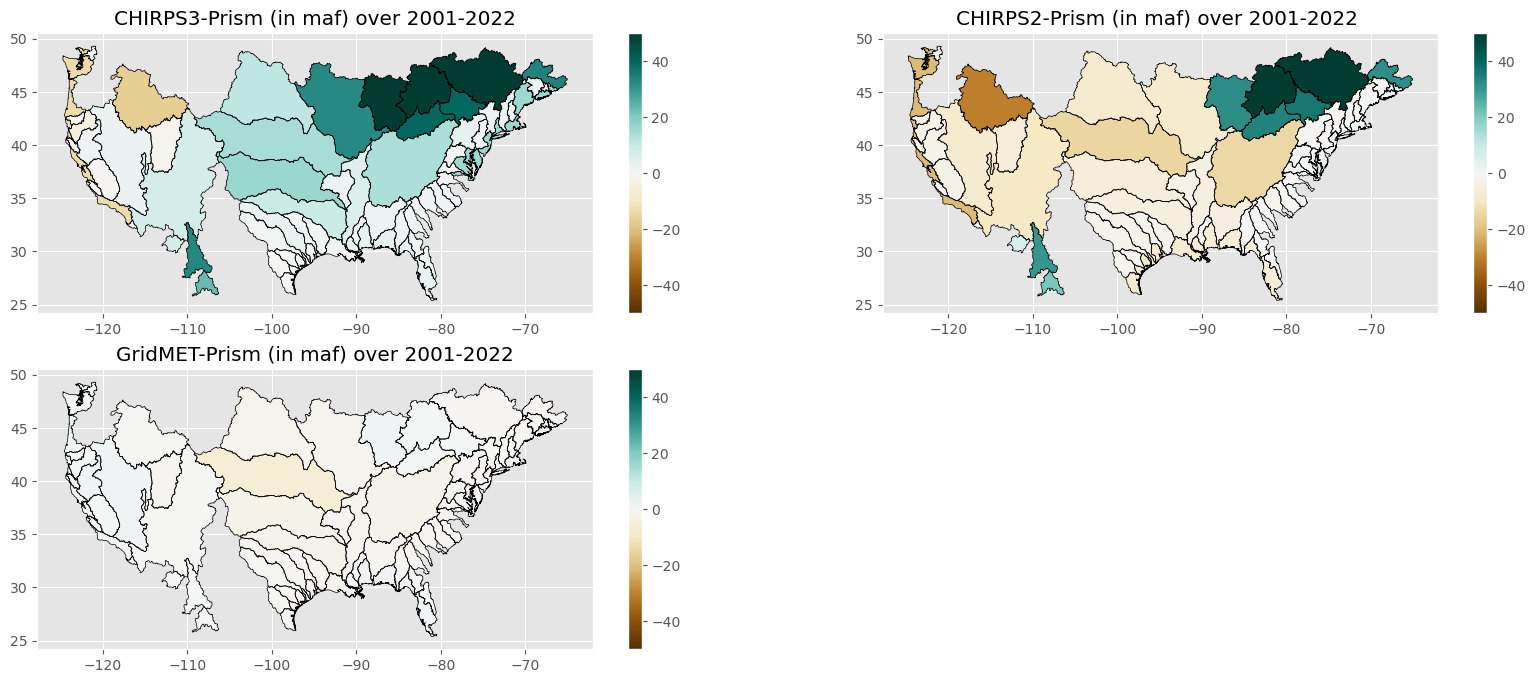

In [173]:
# Plot the spatial map of the difference
fig, axes = plt.subplots(2, 2, figsize=(20, 8))
axes=axes.flatten()
ax=axes[0]

vmin=-50; vmax=50
merged_df.plot(column='chirps3-prism', cmap='BrBG', vmin=vmin, vmax=vmax, legend=True, ax=ax)
# Set the title and display the plot
ax.set_title("CHIRPS3-Prism (in maf) over 2001-2022")
merged_df.boundary.plot(color='k', ax=ax, lw=0.5)
ax=axes[1]
merged_df.plot(column='chirps2-prism', cmap='BrBG', vmin=vmin, vmax=vmax, legend=True, ax=ax)
# Set the title and display the plot
ax.set_title("CHIRPS2-Prism (in maf) over 2001-2022 ")
merged_df.boundary.plot(color='k', ax=ax, lw=0.5)
ax=axes[2]
merged_df.plot(column='gridmet-prism', cmap='BrBG', vmin=vmin, vmax=vmax, legend=True, ax=ax, k=10)
# Set the title and display the plot
ax.set_title("GridMET-Prism (in maf) over 2001-2022")
merged_df.boundary.plot(color='k', ax=ax, lw=0.5)

fig.delaxes(axes[3])

Figure = '{}/plot_difference_basin_avg_precip_conus.png'.format(plotdir)
print (Figure)
plt.savefig(Figure, dpi=150, format='png', bbox_inches='tight')